# The Milwaukee Journal Sentinel and Pothole fill times

**Story:** 

* [Milwaukee database, statistical software show pothole disparity](http://archive.jsonline.com/news/milwaukee/32580074.html)
* [Race gap found in pothole patching](https://web.archive.org/web/20081223094123/http://www.jsonline.com/news/milwaukee/32580034.html)

**Author:** Grant Smith, Ben Poston, Keegan Kyle, Milwaukee Journal Sentinel

**Topics:** Census Data, Geocoding, QGIS Spatial Joins, Linear Regression

**Datasets**

* Pothole fill data from the Milwaukee [Department of Public Works](https://city.milwaukee.gov/dpw)
    - **2007-2010 POTHOLES.xls**: Pothole data, July 2007-July 2010
    - **2010-2013 POTHOLES.xls**: Pothole data, July 2010-July 2013
    - **2013-2017 POTHOLES.xls**: Pothole data, July 2013-July 2017
* **tl_2013_55_tract.zip:** 2013 census tract boundaries from the [US Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php)
* **addresses_geocoded.csv:** a large selection of addresses in Milwaukee, geocoded by [Geocod.io](https://geocod.io)
* **R12216099_SL140.csv:** ACS 2013 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table A04001, Hispanic or Latino by Race
    - `R12216099.txt` is the data dictionary
* **R12216226_SL140.csv** ACS 2013 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table A14006, 2013 Median Household income
    - Data dictionary [is here](https://www.socialexplorer.com/data/ACS2013_5yr/metadata/?ds=SE&table=A14006)

# What's the story?

We're trying to figure out if the **time it took Milwaukee to fill pot holes** is related to the racial makeup of a census tract.

<p class="reading-options">
  <a class="btn" href="/milwaukee-potholes/homework-milwaukee-journal-sentinel-and-potholes-completed">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/milwaukee-potholes/notebooks/Homework - Milwaukee Journal Sentinel and potholes (Completed).ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="#">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **2007-2010 POTHOLES.xls:** 2007-2010 pothole data - 2007-2010 combined pothole data
* **2010-2013 POTHOLES.xls:** 2010-2013 pothole data - 2010-2013 pothole data
* **2013-2017 POTHOLES.xls:** 2013-2017 pothole data - 2013-2017 pothole data
* **tl_2013_55_tract.zip:** census tract shapefile - census tracts including Milwaukee for spatial joining
* **addresses_geocoded.csv:** geocoded addresses - geocoded pothole addresses
* **R12216226_SL140.csv:** median income census data - American Community Survey table A14006
* **R12216099_SL140.csv:** racial makeup census data - American Community Survey table A04001


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/2007-2010 POTHOLES.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/2010-2013 POTHOLES.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/2013-2017 POTHOLES.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/tl_2013_55_tract.zip -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/addresses_geocoded.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/R12216226_SL140.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/R12216099_SL140.csv -P data

# Do your imports

You'll also want to set pandas to display **up to 200 columns at a time**.

In [1]:
import pandas as pd

pd.set_option("display.max_columns", 200)

%matplotlib inline

# Create a dataframe of potholes from only 2013

The delivered multiple files to us, so we'll need to filter them down to just 2013.

**Editorial decision:** When we say "a pothole from 2013," what exactly do we mean?

In [2]:
potholes_2010 = pd.read_excel("data/2010-2013 POTHOLES.xls")
potholes_2013 = pd.read_excel("data/2013-2017 POTHOLES.xls")
potholes = pd.concat([potholes_2010, potholes_2013])
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt
0,3839,N 10TH ST,2013-07-15 23:35,2013-07-16 05:46,2013-07-17 05:50
1,4900,W MELVINA ST,2013-07-15 20:05,2013-07-16 05:46,2013-07-24 16:58
2,2400,W WISCONSIN AV,2013-07-15 20:00,2013-07-16 05:56,2013-07-25 14:42
3,1800,W HAMPTON AV,2013-07-15 19:55,2013-07-16 05:46,2013-07-18 06:06
4,4718,N 19TH ST,2013-07-15 19:50,2013-07-16 05:46,2013-08-02 06:08


In [3]:
potholes = potholes[potholes.EnterDt.str.startswith('2013')]
potholes.shape

(12836, 5)

## What is the maximum and minimum `EnterDt` and `ResolvDt`?

Use this to confirm that your date range is what you expected. If it isn't, take a look at what might have happened with your dataset.

* **Tip:** Missing data might be a headache

In [4]:
potholes.EnterDt.dropna().agg(['min', 'max'])

min    2013-01-02 06:31
max    2013-12-31 17:06
Name: EnterDt, dtype: object

In [5]:
potholes.ResolvDt.dropna().agg(['min', 'max'])

min    2013-01-02 06:33
max    2014-01-23 17:05
Name: ResolvDt, dtype: object

## Calculate how long it took to fill potholes in 2013

Save it into a new column.

* **Tip:** It's possible to subtract two dates

In [6]:
potholes['EnterDt'] = pd.to_datetime(potholes.EnterDt)
potholes['ResolvDt'] = pd.to_datetime(potholes.ResolvDt)
potholes['difference'] = potholes.ResolvDt - potholes.EnterDt
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt,difference
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56,2013-07-25 14:42:00,9 days 18:42:00
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46,2013-07-18 06:06:00,2 days 10:11:00
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46,2013-08-02 06:08:00,17 days 10:18:00


### Hrm, well, I think we need that difference to be an integer

If your new column isn't an integer, create _another_ column that is.

* **Tip:** Just like you might use `.str.strip()` on a string column, if your column is a datetime you can use `.dt.components` to get the days, hours, minutes, seconds, etc of the column.

In [7]:
potholes['wait_days'] = potholes['difference'].dt.components['days'] + \
                        potholes['difference'].dt.components['hours'] / 24
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00,1.250000
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00,8.833333
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56,2013-07-25 14:42:00,9 days 18:42:00,9.750000
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46,2013-07-18 06:06:00,2 days 10:11:00,2.416667
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46,2013-08-02 06:08:00,17 days 10:18:00,17.416667


# Read in your census data

* **Tip:** This will probably give you an error the first time you try, because the Census Bureau doesn't think about the rest of the world.

In [8]:
census = pd.read_csv("data/R12216099_SL140.csv", encoding='latin-1', dtype={'Geo_FIPS': 'str'})
census.head(2)

,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATECE,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_PLACESE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITSCE,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_UACP,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_VTD,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017
0,55079000101,14000US55079000101,"Census Tract 1.01, Milwaukee County, Wisconsin","Census Tract 1.01, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4717,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5306,5015,1343,3567,13,70,0,16,6,291,37,0,0,0,0,254,0
1,55079000102,14000US55079000102,"Census Tract 1.02, Milwaukee County, Wisconsin","Census Tract 1.02, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4718,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3648,3549,1034,2195,36,118,0,0,166,99,67,32,0,0,0,0,0


## Create new dataframe describing the racial makeup of each census tract

Each row should contain:

* The census tract number
* The percent of the population that is White
* The percent of the population that is Black
* The percent of the population that is Hispanic
* The percent of the population that is a minority (non-White)

You can either calculate and filter on the original shapefile, or create a whole new dataframe.

* **Tip:** You'll want to read the data dictionary for the Census data.
* **Tip:** The column names don't exactly match the data dictionary, but you can figure it out
* **Tip:** If you aren't sure which column is the actual census tract number, you can keep multiples for now

In [9]:
census['pct_white'] = census.SE_A04001_003 / census.SE_A04001_001 * 100
census['pct_black'] = census.SE_A04001_004 / census.SE_A04001_001 * 100
census['pct_hispanic'] = census.SE_A04001_010 / census.SE_A04001_001 * 100
census['pct_minority'] = 100 - census.pct_white
census = census[['Geo_FIPS', 'pct_white', 'pct_black', 'pct_hispanic', 'pct_minority']]
census.head()

,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority
0,55079000101,25.310969,67.225782,5.484357,74.689031
1,55079000102,28.344298,60.169956,2.713816,71.655702
2,55079000201,24.733876,55.458151,16.113546,75.266124
3,55079000202,42.488931,44.433903,2.783049,57.511069
4,55079000301,75.056012,16.430172,0.000000,24.943988


# Combine this census data with your street address data

Create a new dataframe my merging your street addresses with your census data. It would be nice to marge on census tract code, but your addresses data does **not** have a census tract on them! **This is where things get a little crazy.**

### Adding census tract codes to addresses

We went ahead and geocoded many addresses in Milwaukee to create `addresses_geocoded.csv`. You'll need to add a new column using QGIS that adds in the address's census tract.

The QGIS command **Join attributes by location** will merge datasets that geographically overlap each other. If you have one layer that's a list of lat/lon points and one layer that's a shapefile with census tract information, **join attributes by location** can create a new layer of lat/lon points that also has census tract information.

You can export the result by right clicking the layer, selecting **Export As** and making sure the output is another CSV.

### Merging

Now you'll have three datasets:

* Addresses and pothole fill ties
* Census data according with census tract codes
* Addresses with census tract codes

You'll need to merge them each together to create one whole dataset.

In [10]:
addresses_tracts = pd.read_csv("addresses_with_tract.csv", dtype={'GEOID': 'str'})
addresses_tracts.head()

,address,GEOID
0,8900 N 124TH ST,55133200202
1,2200 N TERRACE AV,55079186900
2,1000 N PROSPECT AV,55079186900
3,1700 N PROSPECT AV,55079186900
4,2298 N TERRACE AV,55079186900


In [11]:
merged = addresses_tracts.merge(census, left_on='GEOID', right_on='Geo_FIPS')
merged.head()

,address,GEOID,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority
0,2200 N TERRACE AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943
1,1000 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943
2,1700 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943
3,2298 N TERRACE AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943
4,1400 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943


In [12]:
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00,1.250000
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00,8.833333
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56,2013-07-25 14:42:00,9 days 18:42:00,9.750000
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46,2013-07-18 06:06:00,2 days 10:11:00,2.416667
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46,2013-08-02 06:08:00,17 days 10:18:00,17.416667


In [13]:
potholes['address'] = potholes.A.astype(str) + ' ' + potholes.Street
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days,address
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00,1.250000,3839 N 10TH ST
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00,8.833333,4900 W MELVINA ST
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56,2013-07-25 14:42:00,9 days 18:42:00,9.750000,2400 W WISCONSIN AV
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46,2013-07-18 06:06:00,2 days 10:11:00,2.416667,1800 W HAMPTON AV
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46,2013-08-02 06:08:00,17 days 10:18:00,17.416667,4718 N 19TH ST


In [14]:
merged = merged.merge(potholes, on='address')
merged.head()

,address,GEOID,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days
0,1400 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333
1,1228 E JUNEAU AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000
2,1346 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000
3,1346 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667
4,1230 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000


## Drop rows with missing data

How many rows do you lose?

In [15]:
merged.shape

(12820, 14)

In [16]:
merged = merged.dropna()
merged.shape

(11856, 14)

# Linear regression

Using the `statsmodels` package, run a linear regression to find the coefficient relating percent minority and pothole fill times.

In [17]:
import statsmodels.api as sm

X = merged[['pct_minority']]
X = sm.add_constant(X)
y = merged['wait_days']

model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_days   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     98.92
Date:                Sat, 13 Jul 2019   Prob (F-statistic):           3.24e-23
Time:                        12:26:44   Log-Likelihood:                -46657.
No. Observations:               11856   AIC:                         9.332e+04
Df Residuals:                   11854   BIC:                         9.333e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.7985      0.264     25.715      0.000       6.280       7.317
pct_minority     0.0373      0.004      9.946      0.000       0.030       0.045
==============================================================================
Omnibus:                     5674.093   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30528.208
Skew:                           2.318   Prob(JB):                         0.00
Kurtosis:                       9.348   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Translate that into the form **"every X percentage point change in the minority population translates to a Y change in pot hole fill times"**

In [18]:
# Every +1 percent point change in the minority population translates to a 0.04 day change in pot hole fill times

Do you feel comfortable that someone can understand that? Can you reword it to make it more easily understandable?

In [19]:
# times 25
# Every 25 percent point change in the minority population translates to a 1 day change in pot hole fill times

# Other methods of explanation

While the regression is technically correct, it just does't sound very nice. What other options do we have?

## What's the average wait to fill a pothole between majority-white and majority-minority census tracts?

You'll need to create a new column to specify whether the census tract is majority White or not.

In [20]:
merged['majority_white'] = (merged.pct_white > 50).astype(int)
merged.groupby('majority_white').wait_days.describe()

,count,mean,std,min,25%,50%,75%,max
majority_white,,,,,,,,
0,7879.0,9.978281,13.050119,0.0,1.500000,4.875,13.000000,95.208333
1,3977.0,7.575067,10.945687,0.0,1.166667,3.125,8.708333,91.750000


## How does the average wait time to fill a pothole change as more minorities live in an area?

* **Tip:** Use `.cut` to split the percent minority (or white) into a few different bins.

In [21]:
merged['bin'] = pd.cut(merged.pct_minority, bins=range(0,101,20))
merged.head()

,address,GEOID,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days,majority_white,bin
0,1400 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,1,"(20, 40]"
1,1228 E JUNEAU AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,1,"(20, 40]"
2,1346 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000,1,"(20, 40]"
3,1346 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667,1,"(20, 40]"
4,1230 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000,1,"(20, 40]"


In [22]:
merged.groupby('bin').wait_days.describe()

,count,mean,std,min,25%,50%,75%,max
bin,,,,,,,,
"(0, 20]",1456.0,6.742588,9.743595,0.0,1.125000,2.958333,7.250000,64.750000
"(20, 40]",2113.0,7.743157,11.231985,0.0,1.166667,3.166667,9.083333,91.750000
"(40, 60]",1201.0,9.350853,12.444021,0.0,1.250000,4.000000,11.958333,84.750000
"(60, 80]",2072.0,10.094494,12.883166,0.0,1.541667,4.979167,13.177083,95.208333
"(80, 100]",5014.0,10.055893,13.253221,0.0,1.552083,4.895833,13.041667,93.833333


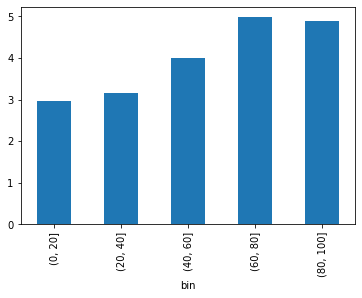

In [23]:
merged.groupby('bin').wait_days.median().plot(kind='bar')

# Bonus: Income

`R12216226_SL140.csv` contains income data for each census tract in Wisconsin. Add it into your analysis.

If you run a multivariate regression also including income, how does this change things?

In [24]:
income = pd.read_csv("data/R12216226_SL140.csv", encoding='latin-1', dtype={'Geo_FIPS': 'str'})
income.head(2)

,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATECE,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_PLACESE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITSCE,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_UACP,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_VTD,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A14006_001
0,55079000101,14000US55079000101,"Census Tract 1.01, Milwaukee County, Wisconsin","Census Tract 1.01, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4717,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27421.0
1,55079000102,14000US55079000102,"Census Tract 1.02, Milwaukee County, Wisconsin","Census Tract 1.02, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4718,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40692.0


In [25]:
income = income[['Geo_FIPS', 'SE_A14006_001']]
income.head(2)

,Geo_FIPS,SE_A14006_001
0,55079000101,27421.0
1,55079000102,40692.0


In [26]:
income['income_10k'] = income.SE_A14006_001 / 10000
income.head(2)

,Geo_FIPS,SE_A14006_001,income_10k
0,55079000101,27421.0,2.7421
1,55079000102,40692.0,4.0692


In [27]:
merged = merged.merge(income, on='Geo_FIPS')
merged.head(2)

,address,GEOID,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days,majority_white,bin,SE_A14006_001,income_10k
0,1400 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,1,"(20, 40]",66875.0,6.6875
1,1228 E JUNEAU AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,1,"(20, 40]",66875.0,6.6875


In [28]:
import statsmodels.api as sm

X = merged[['pct_minority', 'income_10k']]
X = sm.add_constant(X)
y = merged['wait_days']

model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_days   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     70.05
Date:                Sat, 13 Jul 2019   Prob (F-statistic):           5.69e-31
Time:                        12:26:45   Log-Likelihood:                -46637.
No. Observations:               11856   AIC:                         9.328e+04
Df Residuals:                   11853   BIC:                         9.330e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.6729      0.697      3.833      0.000       1.306       4.040
pct_minority     0.0609      0.005     11.583      0.000       0.051       0.071
income_10k       0.6788      0.106      6.392      0.000       0.471       0.887
==============================================================================
Omnibus:                     5676.105   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30709.656
Skew:                           2.317   Prob(JB):                         0.00
Kurtosis:                       9.380   Cond. No.                         438.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

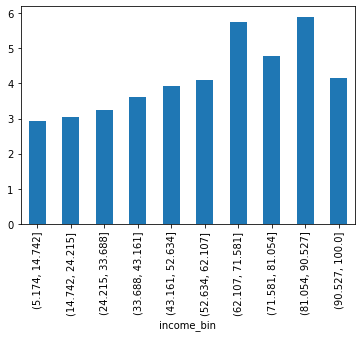

In [29]:
merged['income_bin'] = pd.cut(merged.pct_minority, bins=10)
merged.groupby('income_bin').wait_days.median().plot(kind='bar')